# Getting some insight about the coffee market

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Functions

The following functions are used for making a cleaning of the data and also to make some quick plots.
**correct_df(df, value):** makes sure that the values store in the dataframe df are positive (This is what makes sense for all dfs used in this code), this also transposes the dataframe in order to have year as the index, insted of a column and melts all the country columns into a single one (makes 'Country' a column instead of a dimension).

**plot_highest(df, n, thing):** Just a bar plot of the top n contries that have the most of a 'thing', can be importation, production, consumption, etc.

In [ ]:
def correct_df(df,value):

    if 'Coffee type' in df.columns.tolist():
      df.drop(['Coffee type'], inplace = True, axis = 1) #For this analysis the type of coffee is not considered since the rest of the data doesn't distinguish the type of coffee

    df.set_index('Country', inplace = True) #Uses country as index to later transpose it.

    df = df.T #Transposes and uses year as index and country columns

    df = pd.melt(df, var_name='Country', value_name=value, ignore_index=False) #Melts the country columns for future merging with other dataframes

    df[[value]] = df[[value]].astype(int).abs() #Makes sure all values are positive

    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) #Removes spaces in coutry names

    df = df[~df.index.str.upper().str.contains('TOTAL')] # Removes the 'Total row'

    df.index = df.index.str[:4] #Some dataframes have the year column in the following format: 1994/95, I'm just keeping the first 4 digits since the coffee of the 1994/95 production is sold in 1994.

    df.index = df.index.astype(int)

    df.reset_index(names = ['Year'], inplace = True) # Uses year as simple column and not as index (this is useful when merging)

    return df


def plot_highest(df, n, thing): #n is the number of countries to include

    if 'Coffee type' in df.columns.tolist():
        df = df.drop(['Coffee type'], axis = 1) # Not considered again

    total_by_country_df = df.groupby(['Country'], as_index = False).mean().sort_values(thing, ascending = False) # For these plots the data is groupped by country taking the mean in time.

    top_df = total_by_country_df.head(n) #Selecting the top n

    highlight_color = ['darkred' if country == 'Costa Rica' else 'darkblue' for country in top_df['Country']] # If my country is in there, put it in a different color

    plt.figure(figsize=(10, 6))
    plt.bar(top_df['Country'], top_df[thing], color=highlight_color)
    plt.xlabel('Country')
    plt.ylabel(f'Coffee {thing}')
    plt.title(f'Top {n} Countries with highest {thing}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



 # Import the data

The data came from two places, a kaggle [dataset](https://www.kaggle.com/datasets/michals22/coffee-dataset) from International coffee organization (ICO), and the price data was obtained from the Federal Reserve Economic Data([FRED](https://fred.stlouisfed.org/series/PCOFFOTMUSDM))

In [ ]:
#import all data
domestic_consumption_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_domestic_consumption.csv')
export_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_export.csv')
green_coffee_inventorie_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_green_coffee_inventorie.csv')
import_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_import.csv')
importers_consumption_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_importers_consumption.csv')
production_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_production.csv')
re_export_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/Coffee_re_export.csv')
price_df = pd.read_csv('https://raw.githubusercontent.com/Jorge-Andres-Blanco/Jorge-Andres-Blanco.github.io/main/coffee_EDA/data/coffee-prices-historical-chart-data.csv') # Units are in USD/pound

#Make a dictionary for the variables
dict_variables = {
    'domestic_consumption': domestic_consumption_df,
    'export': export_df,
    'inventory':green_coffee_inventorie_df,
    'import':import_df,
    'importers_consumption':importers_consumption_df,
    'production':production_df,
    're_export': re_export_df
}

## Cleaning

Just apply the correction function

In [ ]:
for var in dict_variables.keys() or 'Country' == dict_variables[var].index.name:
  if 'Country' in dict_variables[var].columns:
    dict_variables[var] = correct_df(dict_variables[var], var) #clean the feature_df
  else:
    print(var) # Just in case it wouldn't work.

The price dataframe is different since it is from another data source, but the cleaning is the same idea

In [ ]:
price_df['date'] = pd.to_datetime(price_df['date'], format = '%Y-%m-%d') # date with the correct datatype
price_df['Year'] = price_df['date'].dt.year # year column

price_df.drop('date', axis = 1, inplace= True) # Eliminate the date column because we only care about yearly data.


price_df = price_df.groupby('Year').mean() # Take the average price for each year
price_df = price_df.loc[1990:2019] # Select the years that are used in the other dataframes
price_df.reset_index(names = 'Year', inplace = True)
price_df.rename(columns={' value': 'price'}, inplace=True)

## Putting it all together

In [ ]:
features_df = functools.reduce(lambda left_df, right_df: pd.merge(left_df, right_df, how='outer', on = ['Year', 'Country']), dict_variables.values())

In [ ]:
complete_df = pd.merge(features_df, price_df)
complete_df

,Year,Country,domestic_consumption,export,inventory,import,importers_consumption,production,re_export,price
0,1990,Angola,1200000.0,5.040000e+06,NaN,NaN,NaN,3.000000e+06,NaN,0.908197
1,1990,Bolivia (Plurinational State of),1500000.0,9.360000e+06,NaN,NaN,NaN,7.380000e+06,NaN,0.908197
2,1990,Brazil,492000000.0,1.016160e+09,NaN,NaN,NaN,1.637160e+09,NaN,0.908197
3,1990,Burundi,120000.0,3.510000e+07,NaN,NaN,NaN,2.922000e+07,NaN,0.908197
4,1990,Ecuador,21000000.0,1.070400e+08,NaN,NaN,NaN,9.024000e+07,NaN,0.908197
...,...,...,...,...,...,...,...,...,...,...
2725,2019,Romania,NaN,NaN,NaN,69900000.0,66480000.0,NaN,3420000.0,1.018240
2726,2019,Slovakia,NaN,NaN,NaN,46380000.0,13620000.0,NaN,32820000.0,1.018240
2727,2019,Slovenia,NaN,NaN,NaN,37200000.0,12240000.0,NaN,24900000.0,1.018240
2728,2019,Russian Federation,NaN,NaN,NaN,355020000.0,289200000.0,NaN,65820000.0,1.018240


## Exploring the roles of some countries

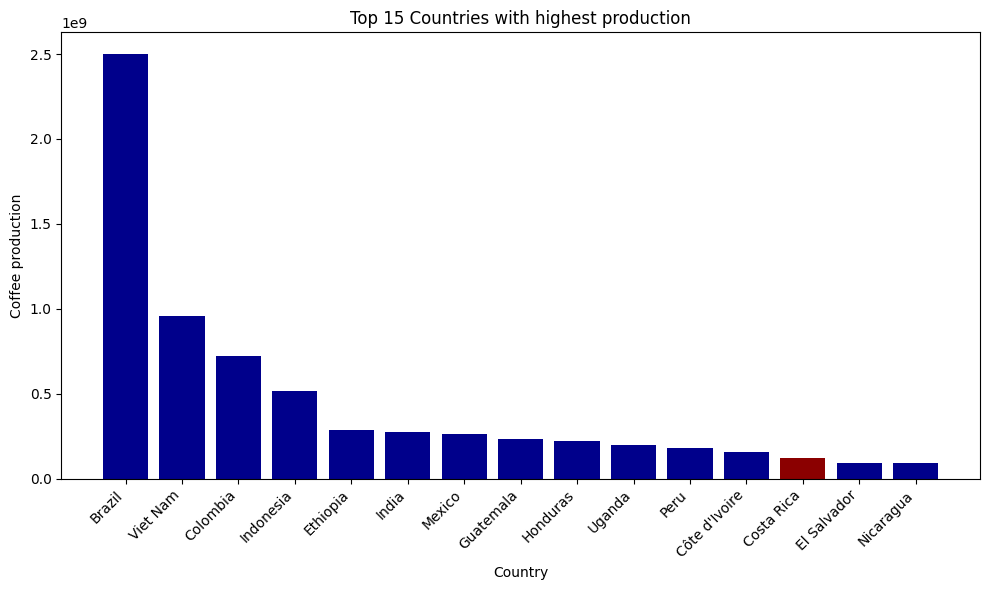

In [ ]:
plot_highest(complete_df, 15, 'production')

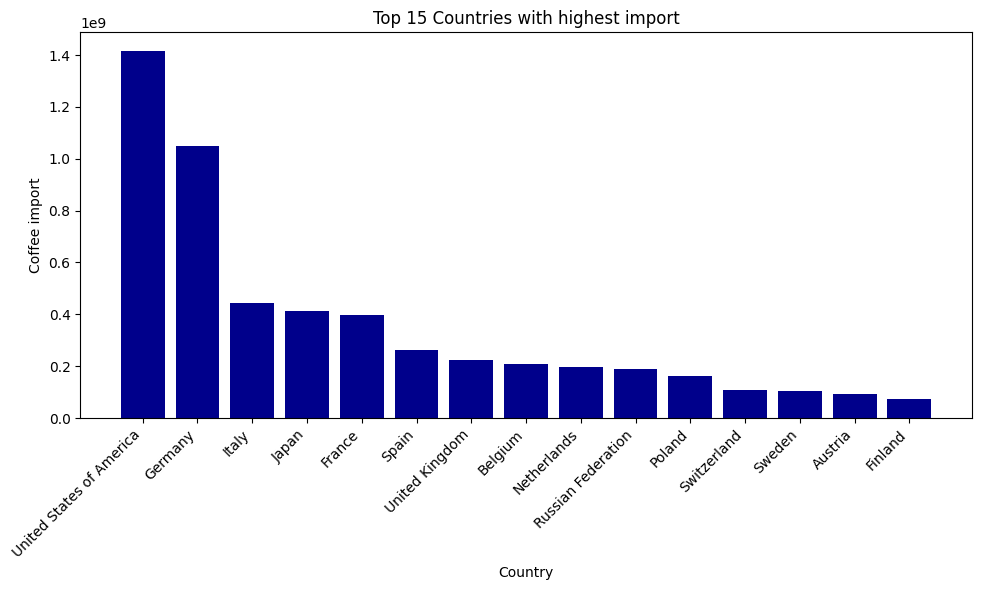

In [ ]:
plot_highest(complete_df, 15, 'import')

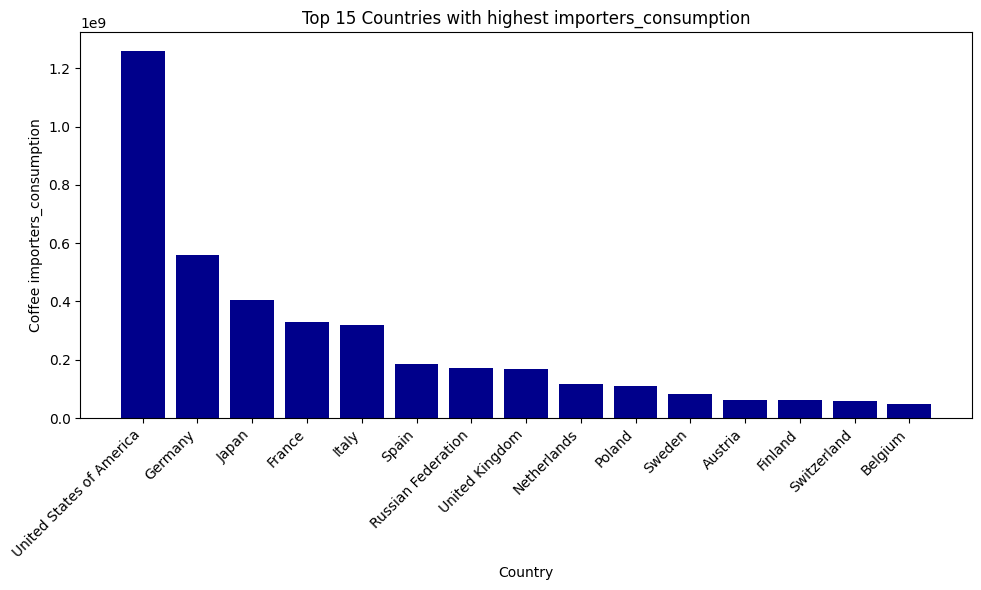

In [ ]:
plot_highest(complete_df, 15, 'importers_consumption')

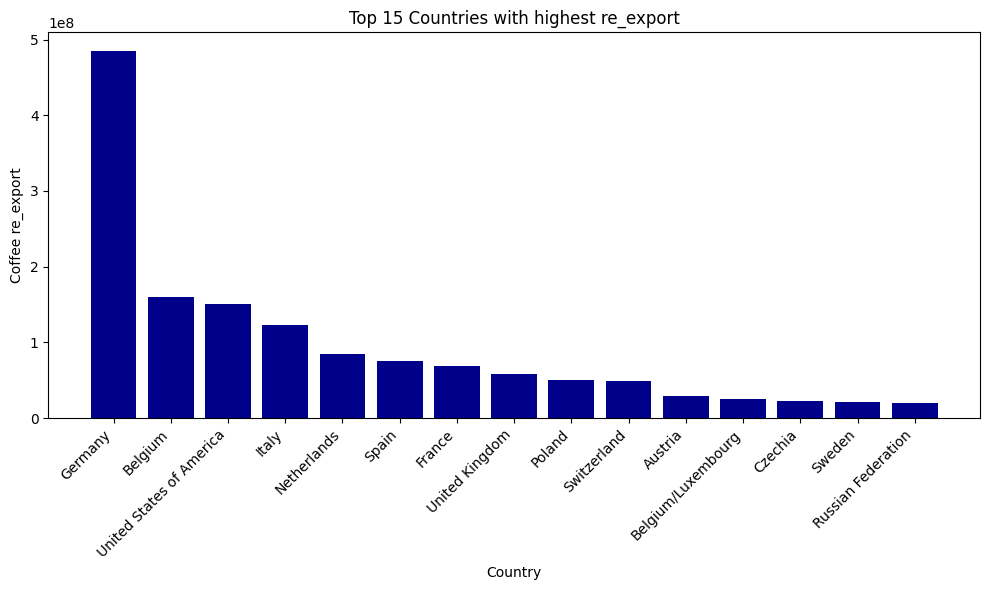

In [ ]:
plot_highest(complete_df, 15, 're_export')

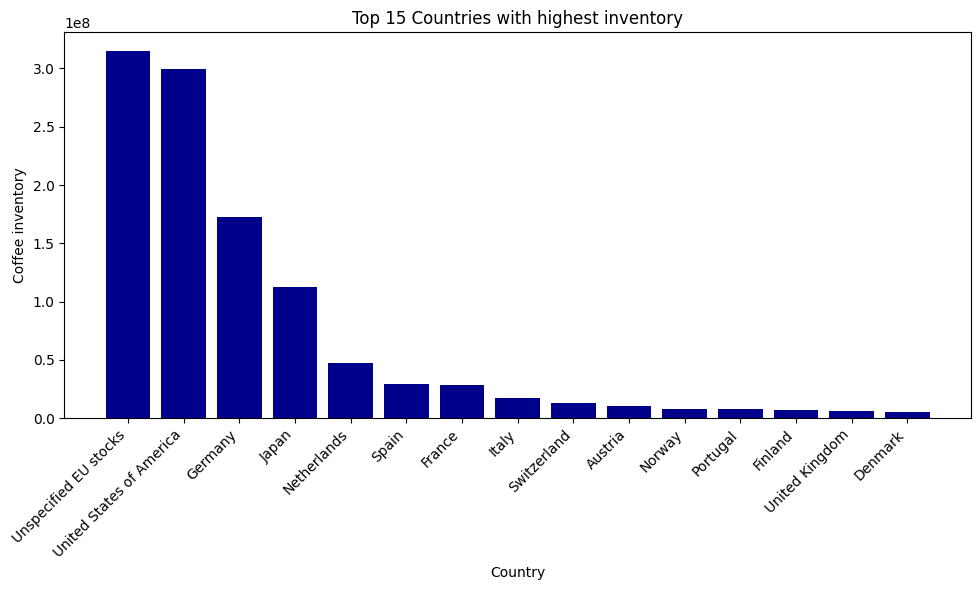

In [ ]:
plot_highest(complete_df, 15, 'inventory')

## Some time series

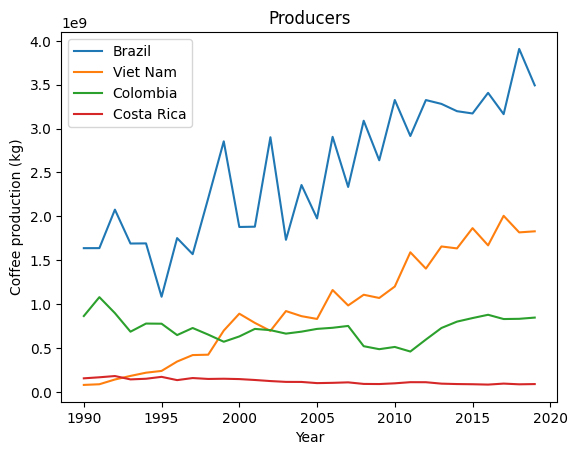

In [ ]:
x = complete_df['Year'].unique()

y_bra = complete_df[complete_df['Country'] == 'Brazil']['production']
y_cr = complete_df[complete_df['Country'] == 'Costa Rica']['production']
y_col = complete_df[complete_df['Country'] == 'Colombia']['production']
y_vie = complete_df[complete_df['Country'] == 'Viet Nam']['production']


plt.plot(x, y_bra, label = 'Brazil')
plt.plot(x, y_vie, label = 'Viet Nam')
plt.plot(x, y_col, label = 'Colombia')
plt.plot(x, y_cr, label = 'Costa Rica')

plt.xlabel('Year')
plt.ylabel('Coffee production (kg)')
plt.title('Producers')
plt.legend()
plt.show()


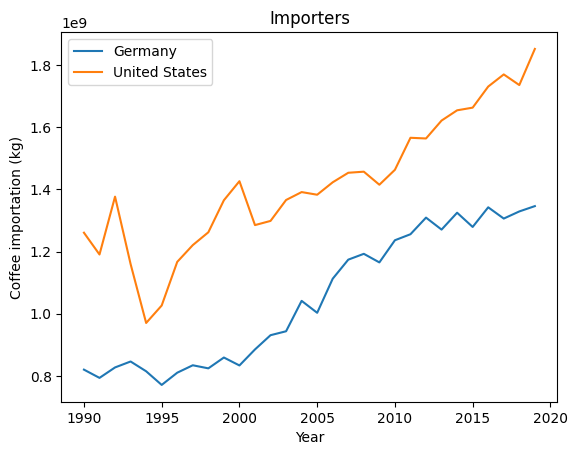

In [ ]:
x = complete_df['Year'].unique()

y_ger = complete_df[complete_df['Country'] == 'Germany']['import']
y_usa = complete_df[complete_df['Country'] == 'United States of America']['import']


plt.plot(x, y_ger, label = 'Germany')
plt.plot(x, y_usa, label = 'United States')


plt.xlabel('Year')
plt.ylabel('Coffee importation (kg)')
plt.title('Importers')
plt.legend()
plt.show()

Considering that there are countries that produce, export or import a big volume of coffee. It would be interesting to see if they have some influence on the price of coffee or other variables of the market

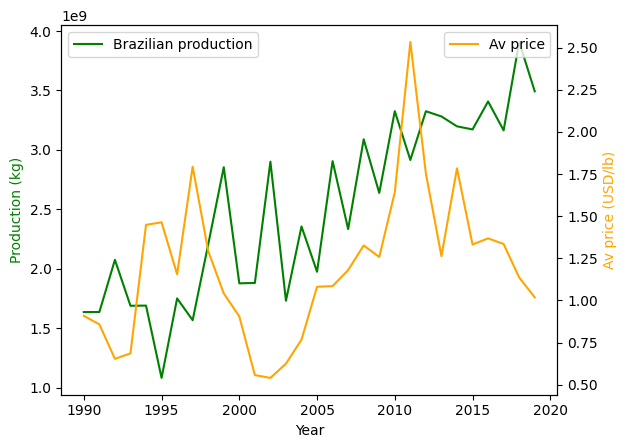

In [ ]:
y_bra = complete_df[complete_df.Country == 'Brazil']['production']
y_pri = complete_df[complete_df.Country == 'Brazil']['price']


fig, ax1 = plt.subplots()

ax1.plot(x,y_bra, color = 'green', label = 'Brazilian production')

ax1.set_ylabel('Production (kg)', color = 'green')
ax1.set_xlabel('Year')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(x,y_pri, color = 'orange', label = 'Av price')

ax2.set_ylabel('Av price (USD/lb)', color = 'orange')
ax2.legend()



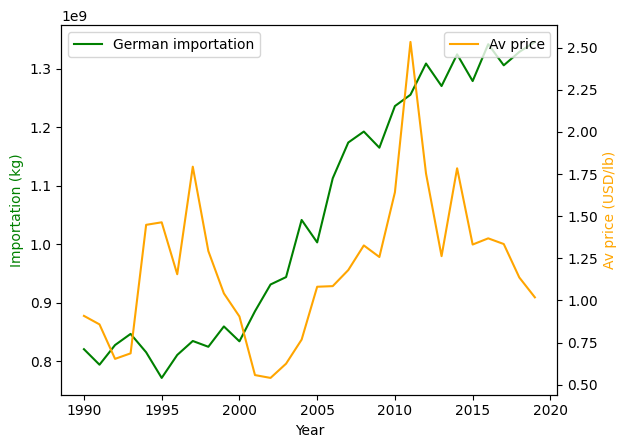

In [ ]:
y_ger = complete_df[complete_df.Country == 'Germany']['import']
y_pri = complete_df[complete_df.Country == 'Germany']['price']


fig, ax1 = plt.subplots()

ax1.plot(x,y_ger, color = 'green', label = 'German importation')

ax1.set_ylabel('Importation (kg)', color = 'green')
ax1.set_xlabel('Year')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(x,y_pri, color = 'orange', label = 'Av price')

ax2.set_ylabel('Av price (USD/lb)', color = 'orange')
ax2.legend()

Looking at this graphs, there is no clear relation between the variables.

In [ ]:
total_year_complete_df = complete_df.drop('Country', axis = 1)
total_year_complete_df = total_year_complete_df.groupby(['Year'], as_index = False).sum()
total_year_complete_df.drop('price', axis = 1, inplace = True)
total_year_complete_df = pd.merge(total_year_complete_df, price_df, on = ['Year'])

Text(0, 0.5, 'Av price (USD/lb)')

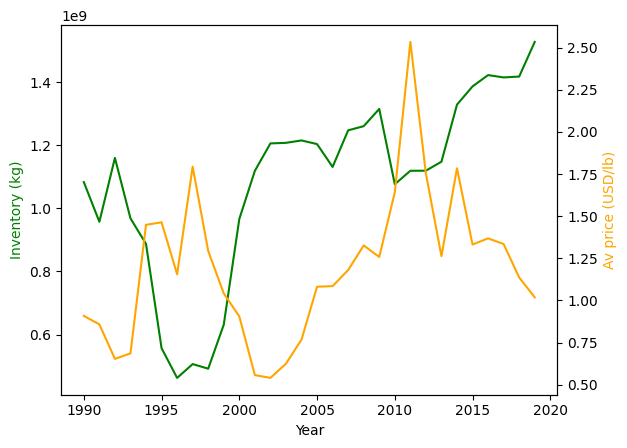

In [ ]:
y_inv = total_year_complete_df['inventory']
y_pri = total_year_complete_df['price']


fig, ax1 = plt.subplots()

ax1.plot(x,y_inv, color = 'green', label = 'Inventory')

ax1.set_ylabel('Inventory (kg)', color = 'green')
ax1.set_xlabel('Year')


ax2 = ax1.twinx()
ax2.plot(x,y_pri, color = 'orange', label = 'Av price')

ax2.set_ylabel('Av price (USD/lb)', color = 'orange')

From this last plot it is visible that, in general, when the inventory is high, the price is lower, but still I believe it is difficult to find a relation between this two variables

r2: 0.0093


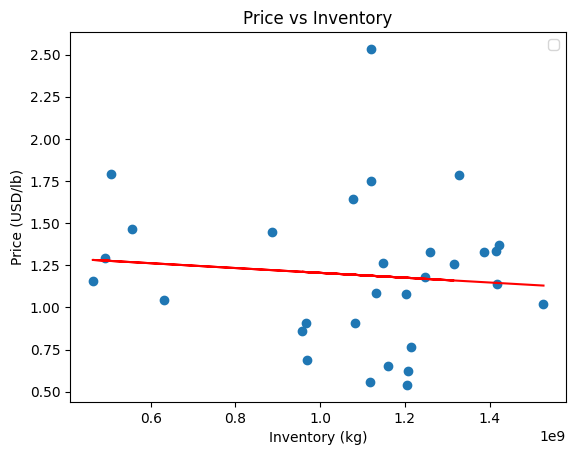

In [ ]:
x = total_year_complete_df[['inventory']]

y = total_year_complete_df['price']

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

plt.scatter(x, y)
plt.plot(x,y_pred, color = 'red')

r2 = r2_score(y, y_pred)

print(f'r2: {r2:.4f}')

plt.xlabel('Inventory (kg)')
plt.ylabel('Price (USD/lb)')
plt.title('Price vs Inventory')
plt.legend()
plt.show()

It appears to be no relation between this variables, however, I'm just going to check the differences.

r2: 0.0167


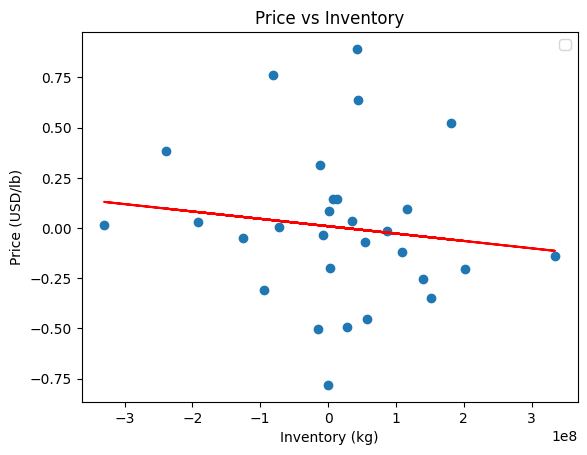

In [ ]:
x = total_year_complete_df[['inventory']].diff().dropna()

y = total_year_complete_df['price'].diff().dropna()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

plt.scatter(x, y)
plt.plot(x,y_pred, color = 'red')

r2 = r2_score(y, y_pred)

print(f'r2: {r2:.4f}')

plt.xlabel('Inventory (kg)')
plt.ylabel('Price (USD/lb)')
plt.title('Price vs Inventory')
plt.legend()
plt.show()

- We conclude that it is better not to predict the price variable

# Variables temporal evolution

R-squared for Year: 1.0000
R-squared for domestic_consumption: 0.9825
R-squared for export: 0.9041
R-squared for inventory: 0.4916
R-squared for import: 0.9755
R-squared for importers_consumption: 0.9385
R-squared for production: 0.8943
R-squared for re_export: 0.9794
R-squared for price: 0.1440


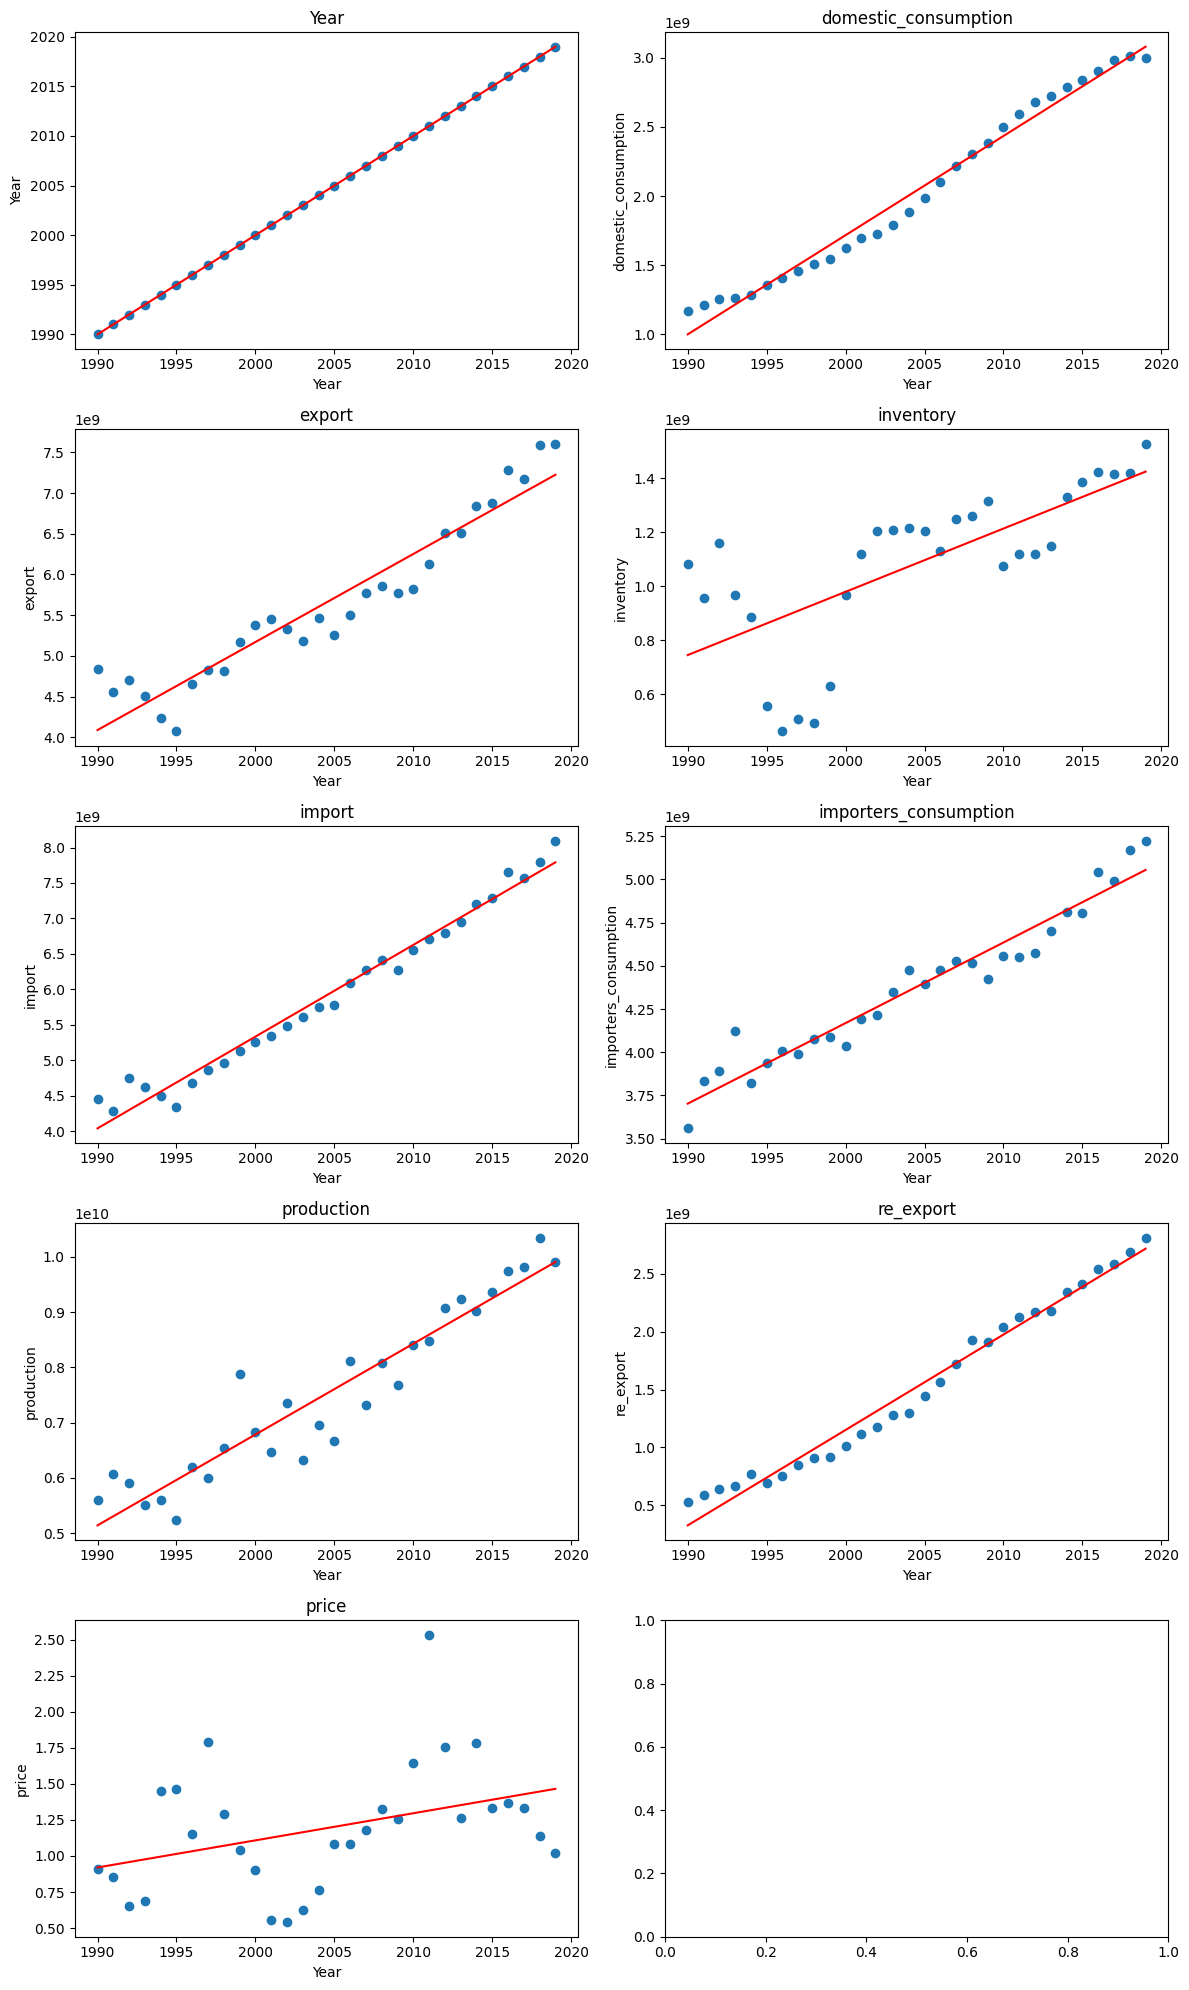

In [ ]:
# Determine the grid size based on the number of features
num_features = len(total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

recalc_total_year_complete_df = total_year_complete_df.copy()

for col in total_year_complete_df.columns:
    #x = total_year_complete_df['Year']
    x = total_year_complete_df[['Year']]
    y = total_year_complete_df[col]


    #model = sm.nonparametric.lowess(y, x, frac=0.6) #returned r2 = 0.0448

    model = LinearRegression()
    model.fit(x, y)

    #y_pred = model[:,1]
    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)

    if r2 >0.3 and col != 'Year':
      recalc_total_year_complete_df[col] = ((total_year_complete_df[col] - y_pred)/y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(col)
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

From this plots one can spot the the coffe market has doubled in size from 1990 to 2019. Considering that this tendency will make all variables correlate very well, we would like to work with the variations from this tendency.

# Modelling the Coffee trade variations
We already know that the coffee trade have a tendency to increase in time. Therefore, we would like to understand and predict the variations from this tendency using the other variables of the dataset. The idea is to have a model that predicts the global trade of coffee in the following manner:

$$ Y_{coffee-trade} = \beta_t t + C + \sum_{i}^{\text{variables}}\beta_i \Delta x_i + \epsilon$$

Were $Y_{coffee-trade}$ is the global coffee trade, which we are going to estimate as the sum of the importations of all countries, this way  $Y_{coffee-trade}$ is our variable 'import' from the total_year_complete_df

The first two terms of the equation represent the temporal tendency that was already mentioned, and the third term represents the variations on the global coffee trade that can be modelled using the variations on other variables of the coffee market, such as production, consumption, etc. And the last term represents the error that exists due to the random nature of the market.

### Looking at the residuals

To obtain the third term of the equation, we are going to predict the residuals from the last (temporal) linear regression using another linear regression:

$$  Y_{coffee-trade} - \beta_t t - C  = \Delta Y_{coffee-trade}=   \sum_{i = 0}^{\text{features}}\beta_i \Delta x_i + \epsilon$$




R-squared for Year: 1.0000
R-squared for domestic_consumption: 0.0392
R-squared for export: 0.0108
R-squared for inventory: 0.0026
R-squared for import: 0.0138
R-squared for importers_consumption: 0.0008
R-squared for production: 0.0060
R-squared for re_export: 0.1368
R-squared for price: 0.1440


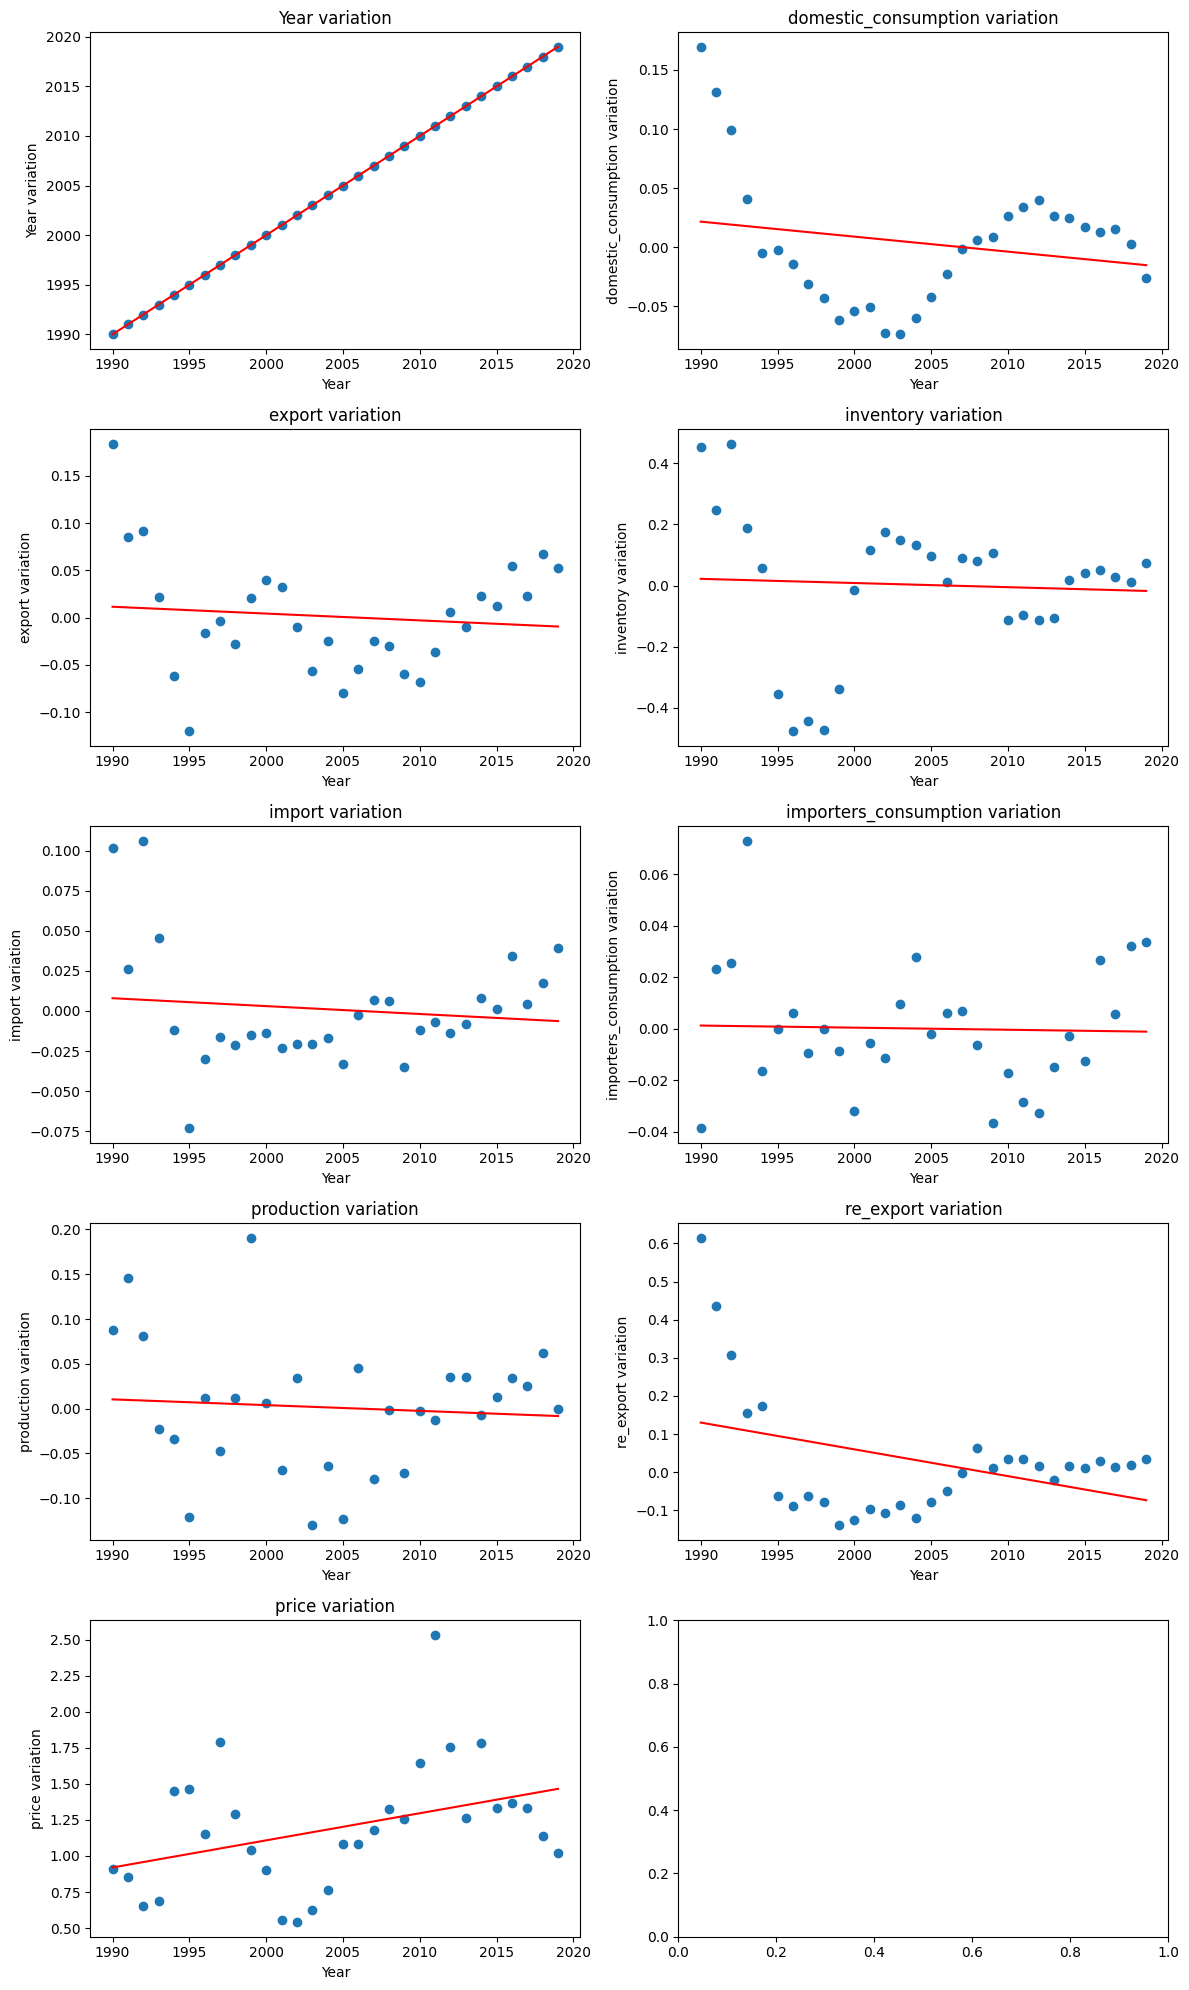

In [ ]:
# Determine the grid size based on the number of features
num_features = len(recalc_total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

for col in recalc_total_year_complete_df.columns:
    x = recalc_total_year_complete_df[['Year']]
    y = recalc_total_year_complete_df[col].tolist()

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(f'{col} variation')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'{col} variation' )
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

From these plots one can see that the residuals are not necessarily normally distributed. To be honest, I don't know how is it going to affect the result, but let's ignore it for the moment...

R-squared for Year: 0.0138
R-squared for domestic_consumption: 0.4709
R-squared for export: 0.6686
R-squared for inventory: 0.4320
R-squared for import: 1.0000
R-squared for importers_consumption: 0.0982
R-squared for production: 0.2493
R-squared for re_export: 0.5930
R-squared for price: 0.0612


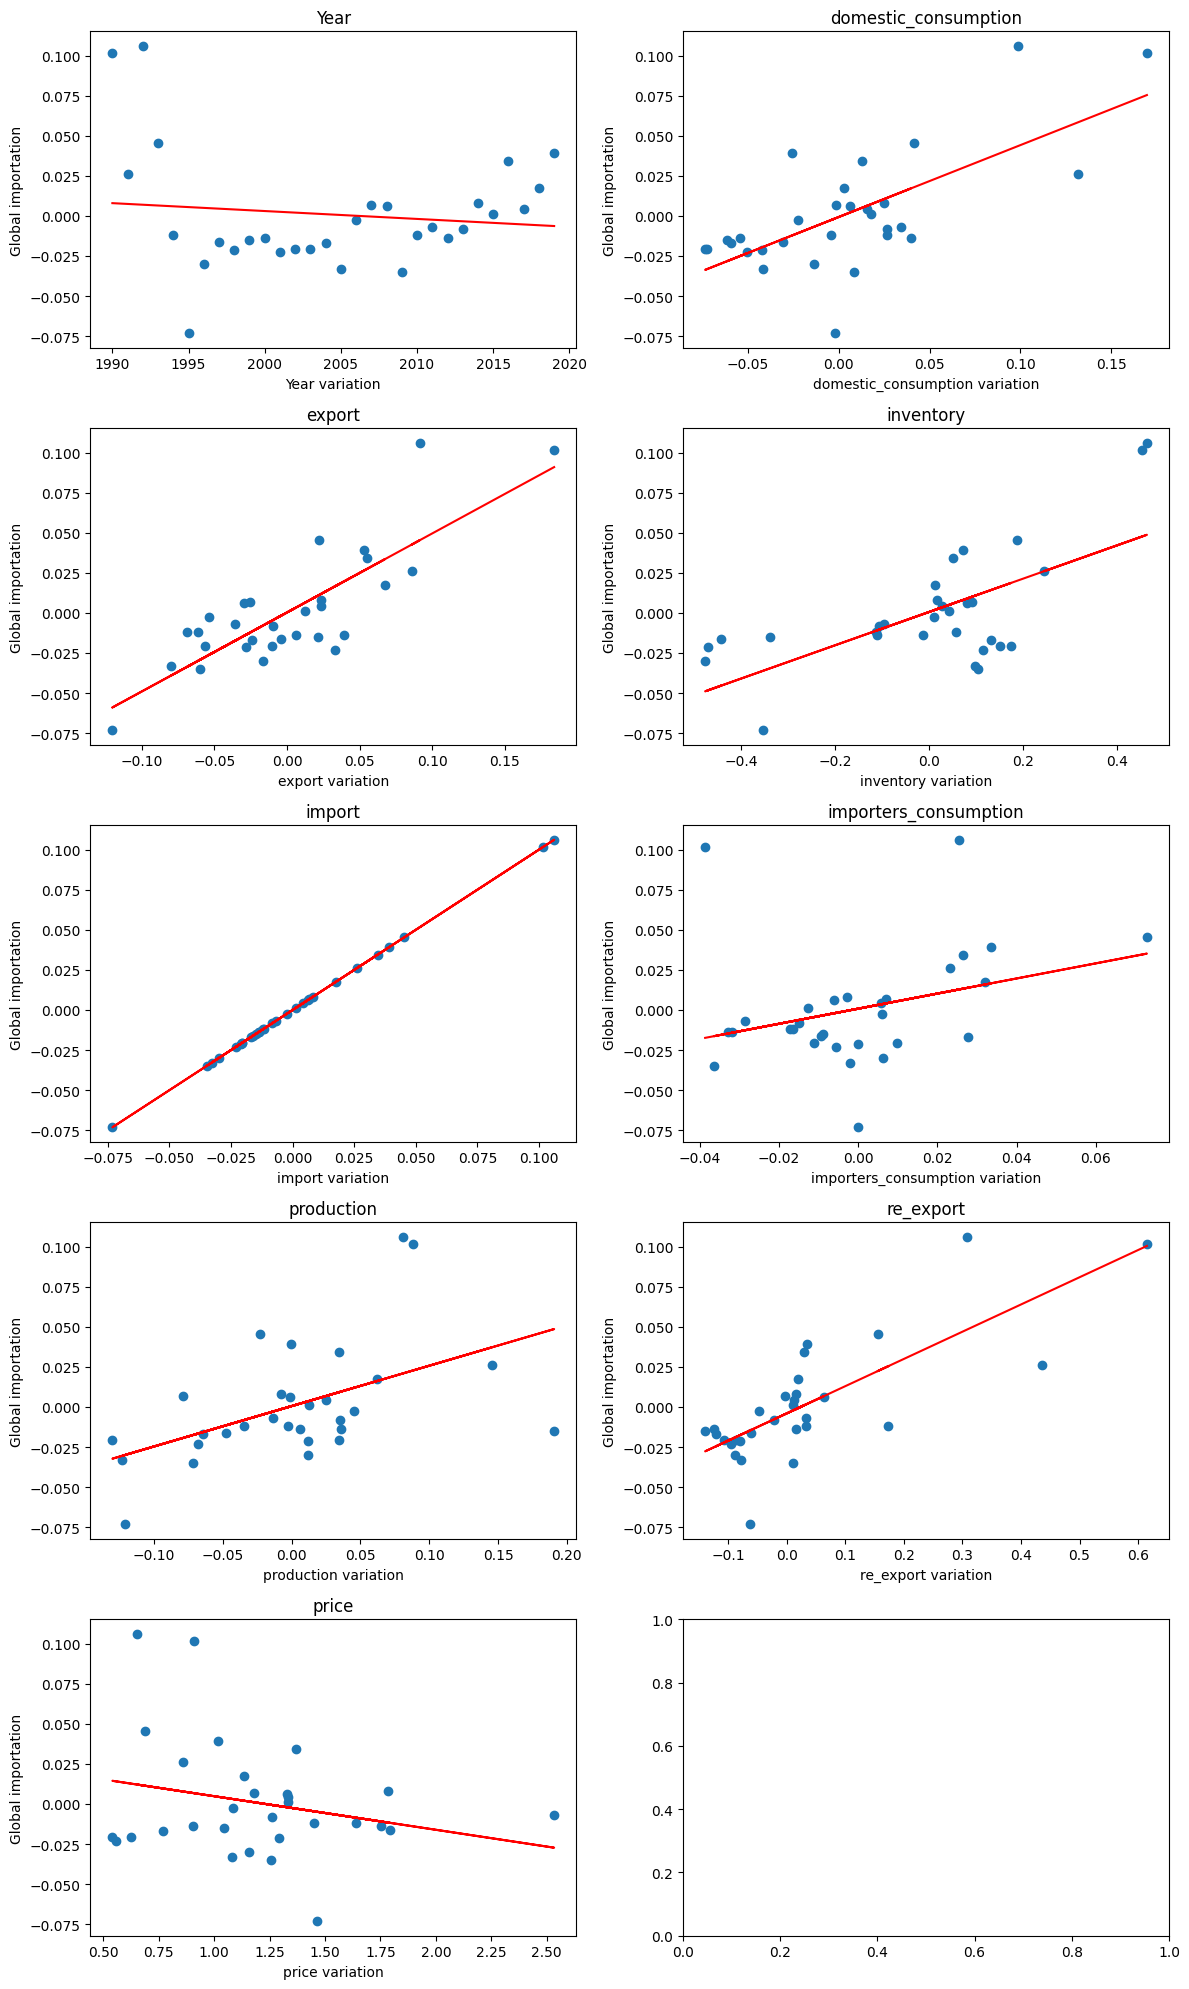

In [ ]:
# Determine the grid size based on the number of features
num_features = len(recalc_total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

for col in recalc_total_year_complete_df.columns:
    x = recalc_total_year_complete_df[[col]]
    y = recalc_total_year_complete_df['import'].tolist()

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(col)
    ax.set_xlabel(f'{col} variation')
    ax.set_ylabel('Global importation')
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

From these plots one coud argue that there is still some variation between these variables, even if the growth of the overall market is 'removed'

In [ ]:
X = recalc_total_year_complete_df.drop(['Year', 'import', 'export'], axis = 1) #Eliminate this variables because it is obvious that they will have an important weight or almost 0 weight.

y = recalc_total_year_complete_df['import']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2}')


# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
print(coefficients)
print("Intercept:")
print(intercept)

Mean Squared Error: 0.0001
R-squared: 0.41701536449847587
Coefficients:
[-0.0226162   0.07501068  0.40243611  0.16724306  0.08606441  0.01301762]
Intercept:
-0.01814200581765537


The R-squared is significant considering the randomness of the market.
The coefficients represent each $\beta$ for the variables on the X dataframe. Therefore we have the following weights:

- **importers_consumption:** 0.4024

- **production:** 0.1672

- **re_export:** 0.08606

- **domestic_consumption:** -0.0226

- **price:** 0.013 -> Least important, suggesting that coffee is an inelastic product

In [ ]:
y_pred_variation = model.predict(X)

before: $r^2$= 0.9754895956750597
after: 0.9945271417184207


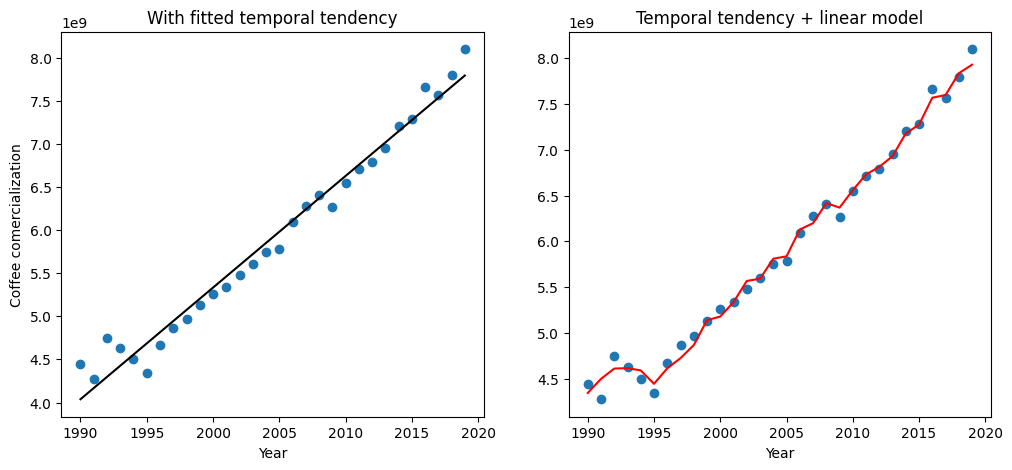

In [ ]:
x = total_year_complete_df[['Year']]
y = total_year_complete_df['import']

model_time = LinearRegression()
model_time.fit(x, y)

y_pred_total = model_time.predict(x)*(1 + y_pred_variation)
r2 = r2_score(y, y_pred_total)

print(r'before: $r^2$'+f'= {r2_score(y, model_time.predict(x))}')
print(f'after: {r2}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(x, y)
axes[0].plot(x, model_time.predict(x), color = 'k')
axes[0].set_title('With fitted temporal tendency')
axes[0].set_ylabel('Coffee comercialization')
axes[0].set_xlabel('Year')

axes[1].scatter(x, y)
axes[1].plot(x, y_pred_total, color = 'red')
axes[1].set_title('Temporal tendency + linear model')
axes[1].set_xlabel('Year')


plt.show()


From this we can see that the model fits reasonable well the data

# Alternative method: Using PCA
Giving that we have 6 variables or features to fit the global trade of coffee (total import), we can use a principal component analysis to reduce the amount of variables

In [ ]:
pca_df = recalc_total_year_complete_df.copy().drop(['Year', 'import', 'export'], axis = 1) #The variables to be reduced

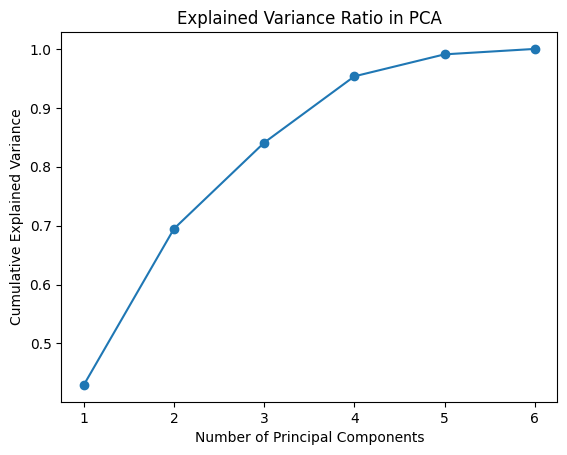

In [ ]:

# Extract numerical features

X = pca_df.select_dtypes(include=['float64', 'int64'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to see the variance that all components explain
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio in PCA')
plt.show()

Given that the first three components explain around 85% of the variance, we are going to reduce it to three.

In [ ]:
num_components = 3 # 3 or 4

# Apply PCA with the chosen number of components
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
columns_pca = [f'PC{i}' for i in range(1, num_components + 1)]
df_pca = pd.DataFrame(data=X_pca, columns=columns_pca)

df_pca

,PC1,PC2,PC3
0,4.965619,1.525853,-1.100696
1,4.098114,0.077040,1.080476
2,3.550419,-1.057556,0.134231
3,1.617418,-2.452643,0.438376
4,0.214603,0.701912,-0.897367
5,-1.757398,0.468689,-0.619387
6,-1.448802,0.270504,1.271806
7,-2.046049,1.349935,0.209706
8,-1.771371,0.468042,1.172329
9,-1.025805,0.407186,2.858292


Now, the idea is to apply the same model as before

R-squared for PC1: 0.7254
R-squared for PC2: 0.0093
R-squared for PC3: 0.0104


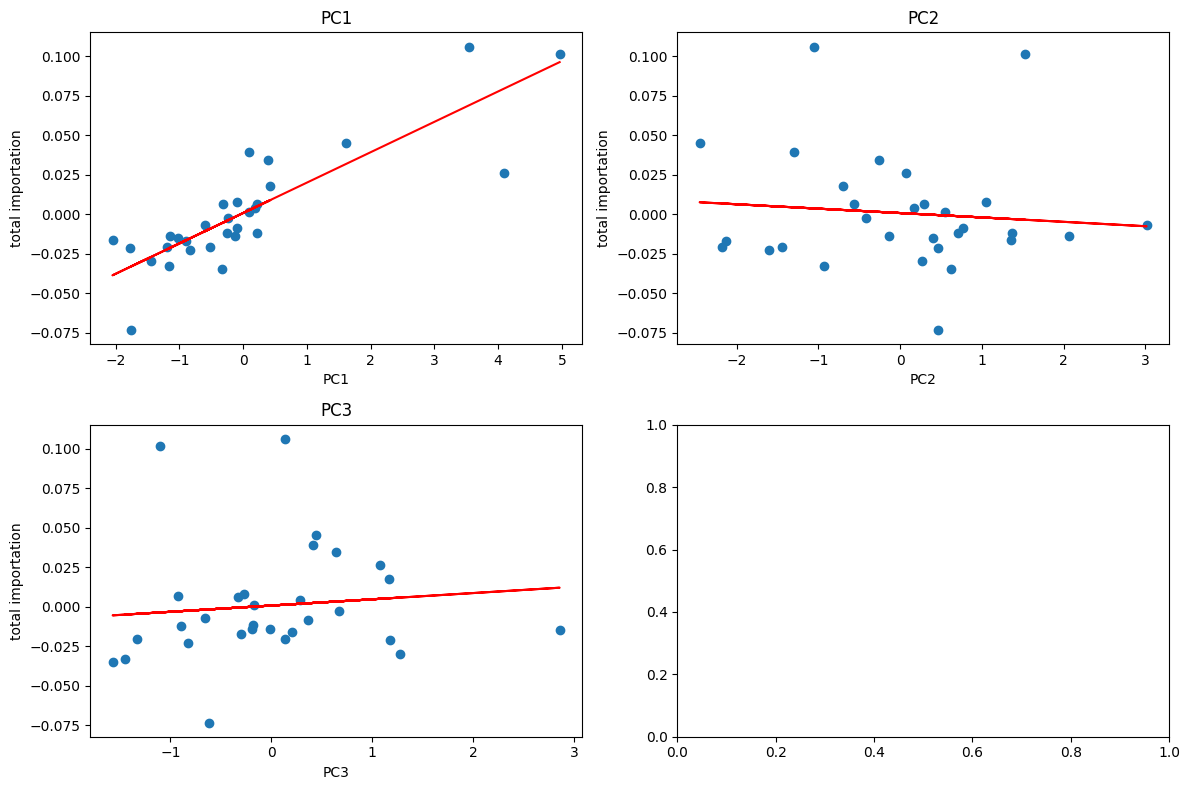

In [ ]:
# Determine the grid size based on the number of features
num_features = len(df_pca.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

for pc in df_pca.columns:
    x = df_pca[[pc]]
    y = recalc_total_year_complete_df['import'].tolist()

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)



    print(f'R-squared for {pc}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{pc} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(pc)
    ax.set_xlabel(pc)
    ax.set_ylabel('total importation')
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
X = df_pca

y = recalc_total_year_complete_df['import']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
print(coefficients)
print("Intercept:")
print(intercept)

Mean Squared Error: 0.0001
R-squared: 0.6129
Coefficients:
[ 0.01923789 -0.00262332  0.00476517]
Intercept:
0.0008474022671263472


The R-squared is significant considering the randomness of the market and is higher than the previous case.
The coefficients represent each $\beta$, as before, but in this case is not a weight of a specific variable, but a weight of a linear combination of all variables, so there is not as much to interpret:

- **PC1:** 0.0192 -> The most important

- **PC3:** 0.0048

- **PC2:** -0.0026

before: 0.9754895956750597
after: 0.992602994664142


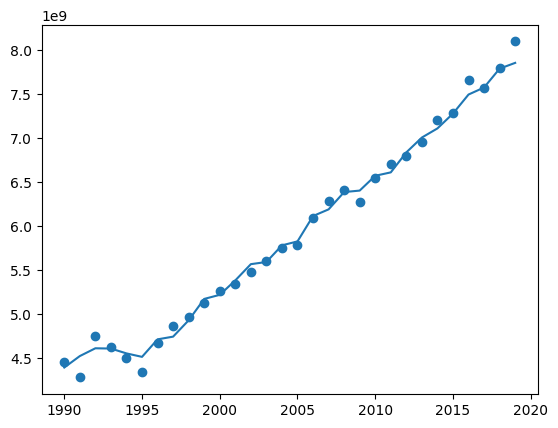

In [ ]:
y_pred_variation = model.predict(X)
x = total_year_complete_df[['Year']]
y = total_year_complete_df['import']

model_time = LinearRegression()
model_time.fit(x, y)

y_pred_total = model_time.predict(x)*(1 + y_pred_variation)
r2 = r2_score(y, y_pred_total)

print(f'before: {r2_score(y, model_time.predict(x))}')
print(f'after: {r2}')

plt.scatter(x, y)
plt.plot(x, y_pred_total)
plt.show()

The model is very similar to the last, the final R-squared is very similar, however, we lose interpretability

## What happens if we make the same analysis but using a different fit for time?

We could say that our trend is not linear and just use a smothing instead of a linear model, this way we would have different residuals due to customed trends for each variable. We'll try a lowess smothing using 50% of the vicinity

R-squared for Year: 1.0000
R-squared for domestic_consumption: 0.9974
R-squared for export: 0.9548
R-squared for inventory: 0.6881
R-squared for import: 0.9888
R-squared for importers_consumption: 0.9610
R-squared for production: 0.9187
R-squared for re_export: 0.9962
R-squared for price: 0.4337


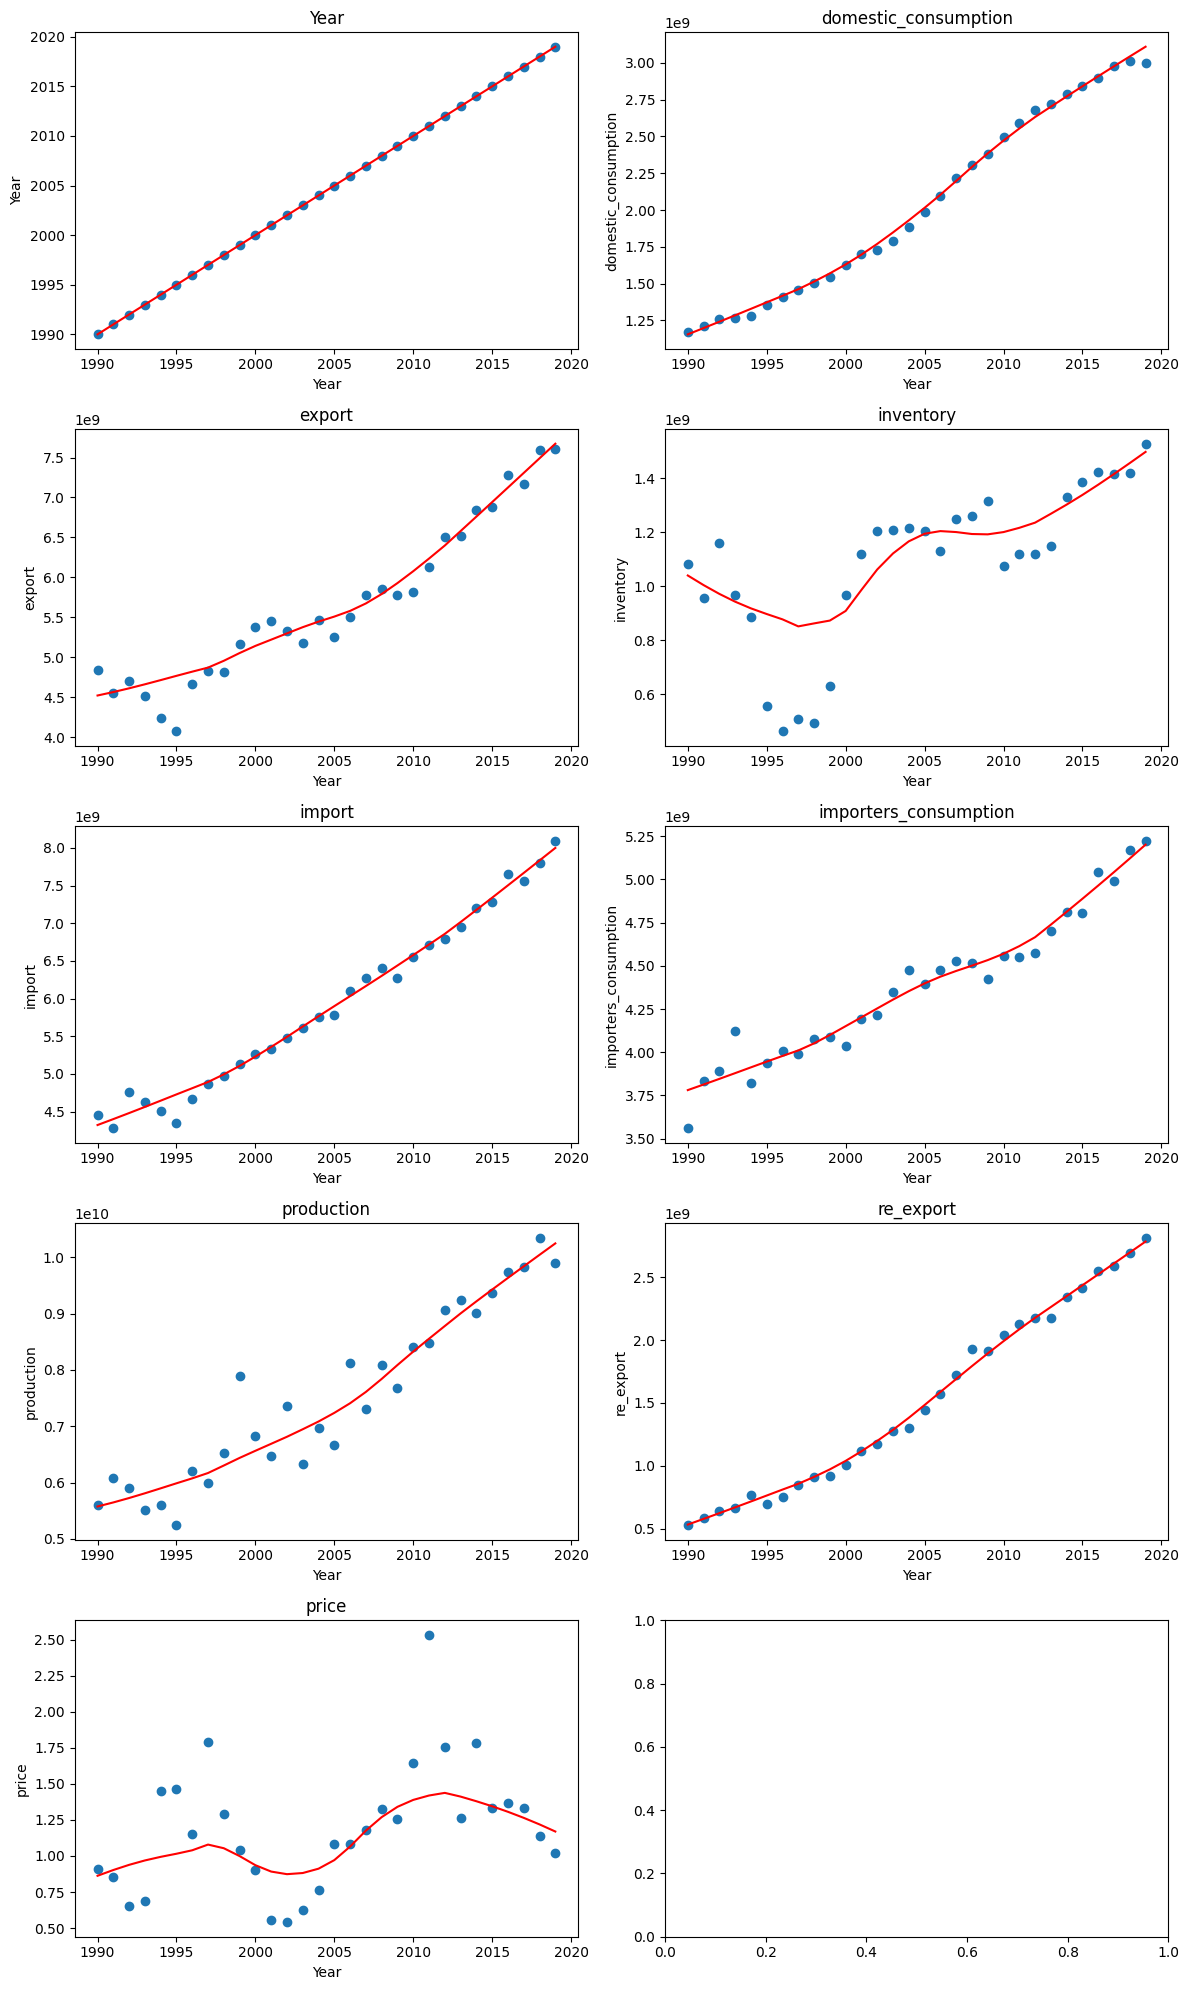

In [ ]:
# Determine the grid size based on the number of features
num_features = len(total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

recalc_total_year_complete_df = total_year_complete_df.copy()

for col in total_year_complete_df.columns:
    x = total_year_complete_df['Year']
    y = total_year_complete_df[col]


    model = sm.nonparametric.lowess(y, x, frac=0.5)

    y_pred = model[:,1]

    r2 = r2_score(y, y_pred)

    if r2 >0.3 and col != 'Year':
      recalc_total_year_complete_df[col] = ((total_year_complete_df[col] - y_pred)/y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(col)
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Residuals

R-squared for Year: 1.0000
R-squared for domestic_consumption: 0.0034
R-squared for export: 0.0169
R-squared for inventory: 0.0547
R-squared for import: 0.0035
R-squared for importers_consumption: 0.0002
R-squared for production: 0.0014
R-squared for re_export: 0.0211
R-squared for price: 0.0004


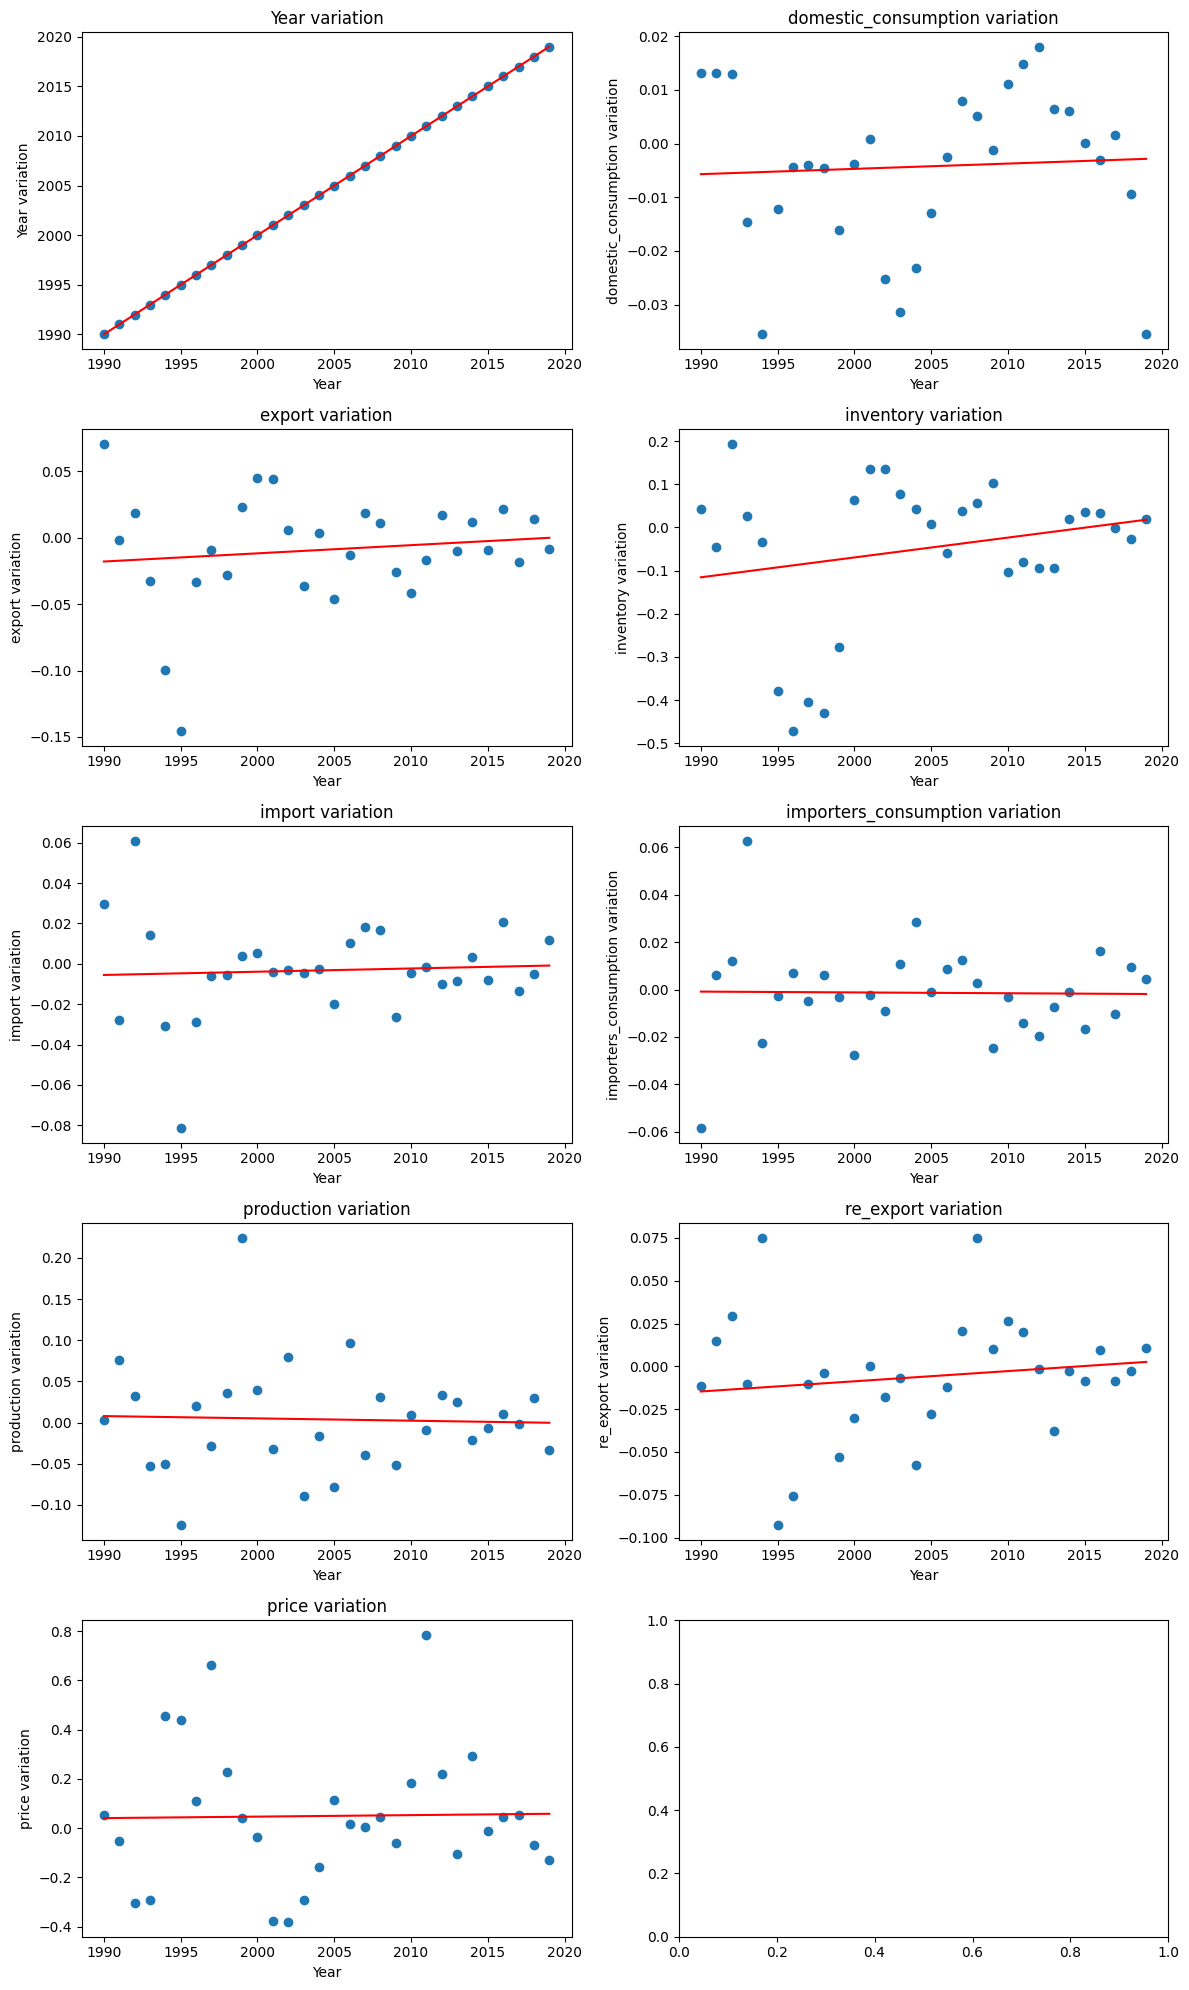

In [ ]:
# Determine the grid size based on the number of features
num_features = len(recalc_total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

for col in recalc_total_year_complete_df.columns:
    x = recalc_total_year_complete_df[['Year']]
    y = recalc_total_year_complete_df[col].tolist()

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(f'{col} variation')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'{col} variation' )
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

R-squared for Year: 0.0035
R-squared for domestic_consumption: 0.0522
R-squared for export: 0.5313
R-squared for inventory: 0.2449
R-squared for import: 1.0000
R-squared for importers_consumption: 0.0198
R-squared for production: 0.1084
R-squared for re_export: 0.1654
R-squared for price: 0.1371


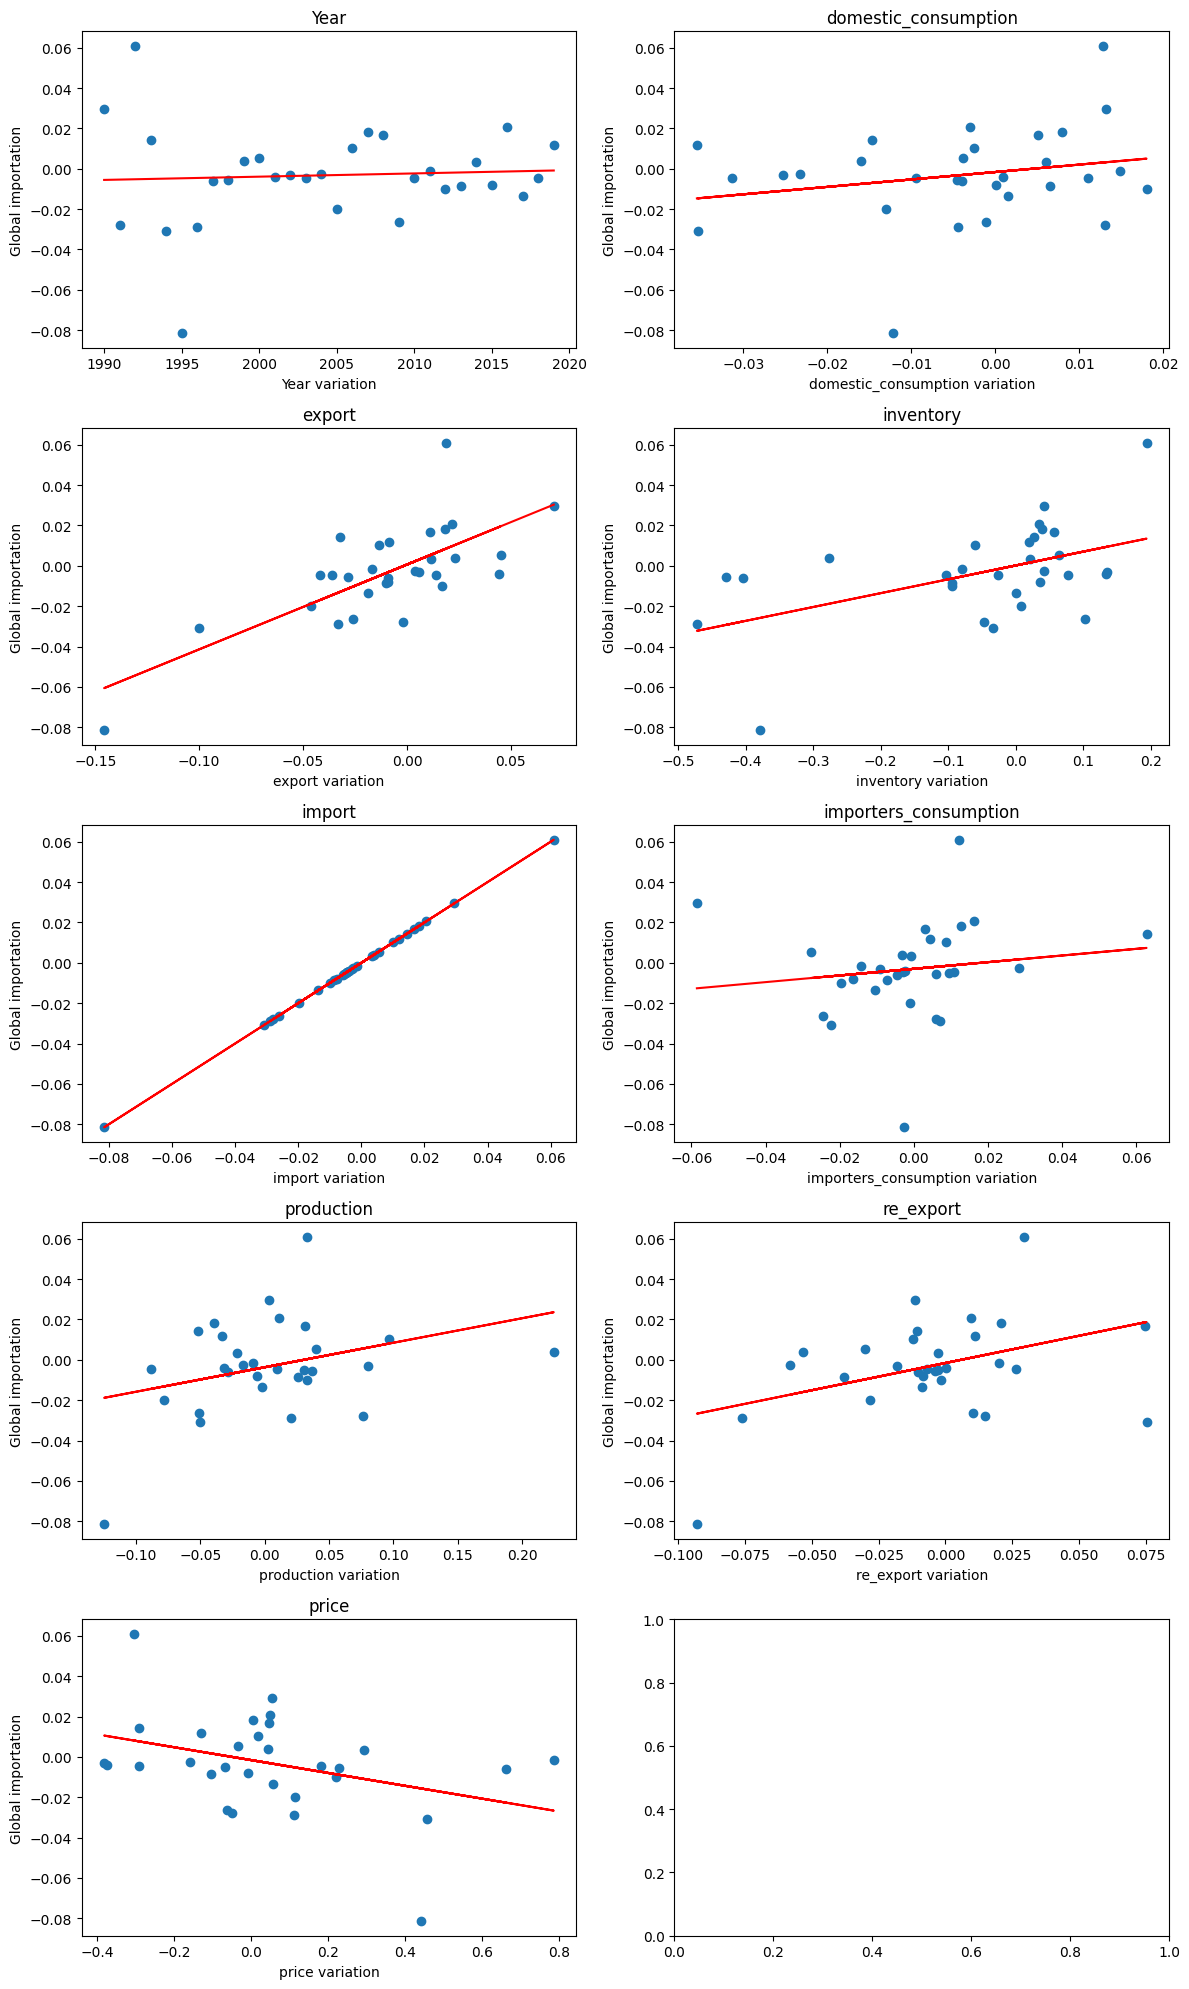

In [ ]:
# Determine the grid size based on the number of features
num_features = len(recalc_total_year_complete_df.columns)
num_rows = (num_features + 1) // 2  # Adjust the number of rows as needed
num_cols = 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()
i=0

for col in recalc_total_year_complete_df.columns:
    x = recalc_total_year_complete_df[[col]]
    y = recalc_total_year_complete_df['import'].tolist()

    model = LinearRegression()
    model.fit(x, y)

    y_pred = model.predict(x)

    r2 = r2_score(y, y_pred)



    print(f'R-squared for {col}: {r2:.4f}')

    # Plot on the current subplot
    ax = axes[i]
    ax.scatter(x, y, label=f'{col} - R2: {r2:.2f}')
    ax.plot(x, y_pred, color='red')
    ax.set_title(col)
    ax.set_xlabel(f'{col} variation')
    ax.set_ylabel('Global importation')
    i+=1
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The coefficients of determination are small, but we can still check linear model is not going to perform great

In [ ]:
X = recalc_total_year_complete_df.drop(['Year', 'import', 'export'], axis = 1) #Eliminate this variables because it is obvious that they will have an important weight or almost 0 weight.

y = recalc_total_year_complete_df['import']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2}')


# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:")
print(coefficients)
print("Intercept:")
print(intercept)

Mean Squared Error: 0.0001
R-squared: 0.09767399054892878
Coefficients:
[0.3162178  0.07758516 0.24847982 0.1199238  0.09132223 0.00078461]
Intercept:
0.0017011706140998973


The R-squared for this model is much smaller than for other methods

# Conclusions

- From this analysis we can demonstrate the inelasticity of coffee as a product. This can be explained by the fact that coffee is a product that people buy to meet their daily habits (part of the routine), it can even be considered part of the occidental culture. Also, this product is sold to countries were the people can afford it  

- The coffee market has grown to double its original size in the last 30 years.

- There are some countries that import and re-export coffee such as germany

- The model built fit the data as expected, but the most important factor is the temporal growing trend of this market, followed by the importers consumption, and the production.
- It would be very interesting to make predictions for the future using this data, technically the model built should be able to make it, however, the temporal trend was fitted using all the data and not tested in a new set.

# Limitations

- The data we have doesn't represent the real dynamics of the market (the coffee is sold in futures, for specific delivery times, etc.)

- Some of the variables used as features to predict the commercialization of coffee may be dependant of the global trade. For instance, the re-export variable may depend on importation and not the other way around.

- It is possible the there are some lags between variables, for example, the production, the trade, and the consuption may occur in different years and the data source does not specify anything about it.